### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 17th at 11.59pm CST
---

##### Only one problem this week

This problem is mostly about generative classification, but will include one discriminative classifer that we'll meet in `Lecture_20`.

1. Use the following code snippet to read in SDSS galaxy color data.
```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```
This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?

In [1]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt

# import data
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()

In [2]:
# printing column names
data.dtype.names

('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')

In [3]:
# creating colour cuts
umg = data['u']-data['g']
gmr = data['g']-data['r']
rmi = data['r']-data['i']
imz = data['i']-data['z']

# redshift and error
rs = data['redshift']
rserr = data['redshift_err']

# specClass array
sc = data['specClass']

In [4]:
# number of objects
ng = np.where(sc == 'GALAXY')[0].shape[0]
nq = np.where(sc == 'QSO')[0].shape[0]

print(f'Number of galaxies = {ng}')
print(f'Number of quasars = {nq}')

Number of galaxies = 42874
Number of quasars = 7126


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.

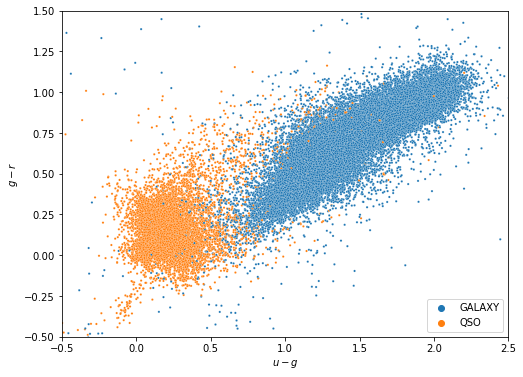

In [6]:
# plot using seaborn - easier to colour by class
import seaborn as sns

plt.figure(figsize=(8,6))
scatter = sns.scatterplot(x=umg, y=gmr, hue=sc, s=5)
scatter.legend(loc='lower right')
plt.xlabel(r'$u-g$')
plt.ylabel(r'$g-r$')
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5);

3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.

In [7]:
# creating new data arrays
X = np.array((umg, gmr, rmi, imz, rs)).T
y = np.unique(sc, return_inverse=True)[1]

# splitting data to train and test
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*

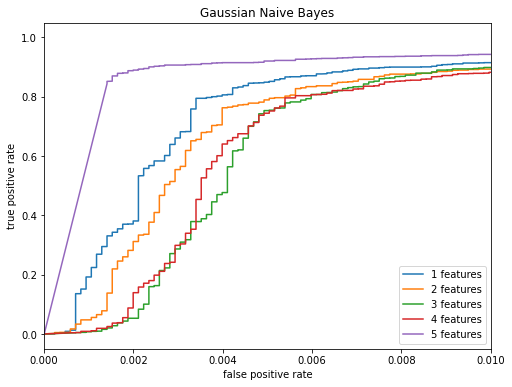

In [9]:
# import GNB and roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve

plt.figure(figsize=(8,6))

# looping across five features
# uses first feature, then first two, then first three etc.
for ii in range(1,6):
    
    gnb = GaussianNB()  # initiate GNB
    gnb.fit(Xtrain[:,:ii], ytrain)  # train data
    
    ypred = gnb.predict_proba(Xtest[:,:ii]) # predict classes
    
    # calculate and plot roc curves
    # use probabilities for quasar classification
    # since ROC finds rms error. Prob between 0 and 1
    # and quasar classed as '1'. Therefore, 0 rms error
    # only if quasar probability is a '1' etc.
    fpr, tpr, thresh = roc_curve(ytest, ypred[:,1])
    
    plt.plot(fpr, tpr, label=f'{ii} features')
    
plt.xlim(0, 0.01)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Gaussian Naive Bayes')
plt.legend(loc='lower right');

It appears that the fifth feature of that dataset (redshift) makes the classification easier, especially since adding more colour cuts apparently decreases accuracy

SRT: Excellent.

5. Repeat (4) for Quadratic Discriminant Analysis. 

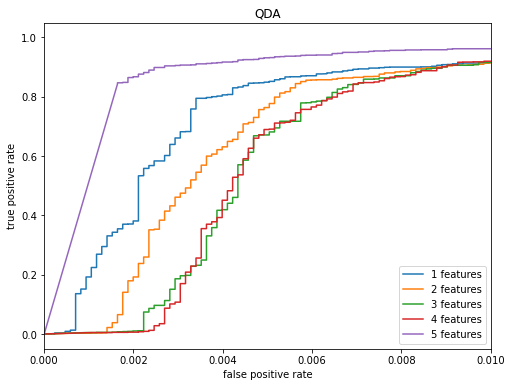

In [10]:
# import QDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

plt.figure(figsize=(8,6))

# looping across five features
# uses first feature, then first two, then first three etc.
for ii in range(1,6):
    
    qda = QuadraticDiscriminantAnalysis()  # initiate GNB
    qda.fit(Xtrain[:,:ii], ytrain)  # train data
    
    ypred = qda.predict_proba(Xtest[:,:ii]) # predict classes
    
    # calculate and plot roc curves
    # use probabilities for quasar classification
    # since ROC finds rms error. Prob between 0 and 1
    # and quasar classed as '1'. Therefore, 0 rms error
    # only if quasar probability is a '1' etc.
    fpr, tpr, thresh = roc_curve(ytest, ypred[:,1])
    
    plt.plot(fpr, tpr, label=f'{ii} features')
    
plt.xlim(0, 0.01)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('QDA')
plt.legend(loc='lower right');

Again, we see that adding the final feature, redshift, is key to classification

6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.

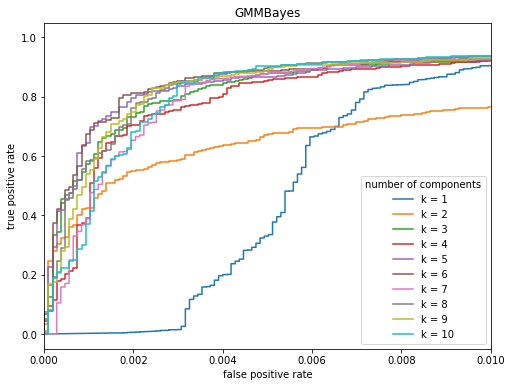

In [35]:
# import GMMBayes
from astroML.classification import GMMBayes

# input dataset only colour cuts
Xc = X[:,:4]

# train test split on colour cuts
Xctrain, Xctest, yctrain, yctest = train_test_split(Xc, y)

plt.figure(figsize=(8,6))

# looping over num of components k between 1 and 10
for k in np.arange(1,11):
    
    gmmb = GMMBayes(k)  # initiate with k comps
    gmmb.fit(Xctrain, yctrain)  # train the classifier
    ycpred = gmmb.predict_proba(Xctest)  # test!
    
    # calculate ROC curves as above
    fpr, tpr, thresh = roc_curve(yctest, ycpred[:,1])
    
    plt.plot(fpr, tpr, label=f'k = {k}')
    
plt.xlim(0, 0.01)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('GMMBayes')
plt.legend(loc='lower right', title='number of components');    

It appears that $k=6$ gives the best performance

SRT: In these kinds of marginal scenarios, rather than judging by eye, the most robust strategy is to find the classifier that maximizes the area under the ROC curve. -2

7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 

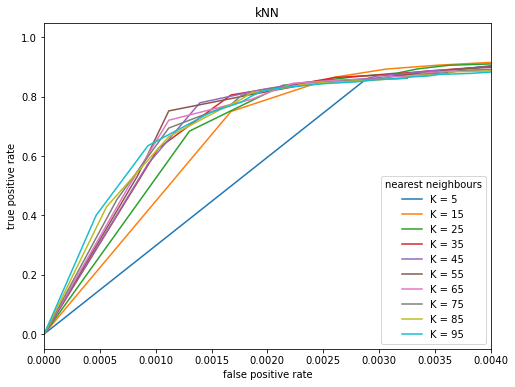

In [41]:
# import KNN
from sklearn.neighbors import KNeighborsClassifier as KNN

plt.figure(figsize=(8,6))

# looping over num of components between 5 and 100 (step=10)
for k in np.arange(5, 100, 10):
    
    knn = KNN(k)  # initiate with k comps
    knn.fit(Xctrain, yctrain)  # train the classifier
    ycpred = knn.predict_proba(Xctest)  # test!
    
    # calculate ROC curves as above
    fpr, tpr, thresh = roc_curve(yctest, ycpred[:,1])
    
    plt.plot(fpr, tpr, label=f'K = {k}')
    
plt.xlim(0, 0.004)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('kNN')
plt.legend(loc='lower right', title='nearest neighbours');    

This one is  tough. For maximising tpr while minimising fpr, it appears that any $K=55$ gives the best levels of performance (brown curve)

SRT: Indeed a tough one. In fact if you ran it again with a different train-test split you might even get a slightly different answer. 

8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 

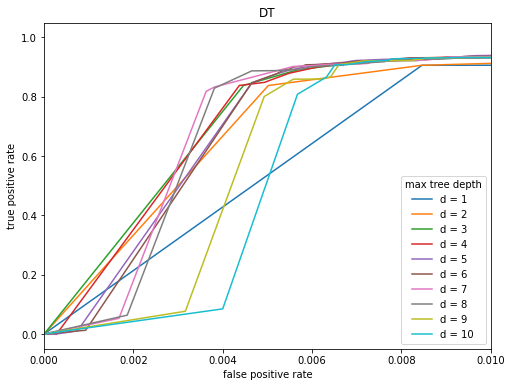

In [43]:
# import DT
from sklearn.tree import DecisionTreeClassifier as DT

plt.figure(figsize=(8,6))

# looping over num of components k between 1 and 10
for d in np.arange(1,11):
    
    dt = DT(max_depth = d)  # initiate with d comps
    dt.fit(Xctrain, yctrain)  # train the classifier
    ycpred = dt.predict_proba(Xctest)  # test!
    
    # calculate ROC curves as above
    fpr, tpr, thresh = roc_curve(yctest, ycpred[:,1])
    
    plt.plot(fpr, tpr, label=f'd = {d}')
    
plt.xlim(0, 0.01)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('DT')
plt.legend(loc='lower right', title='max tree depth'); 

Best performance for a max tree depth of 7 (pink curve), again for maximising tpr while minimising fpr

9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 

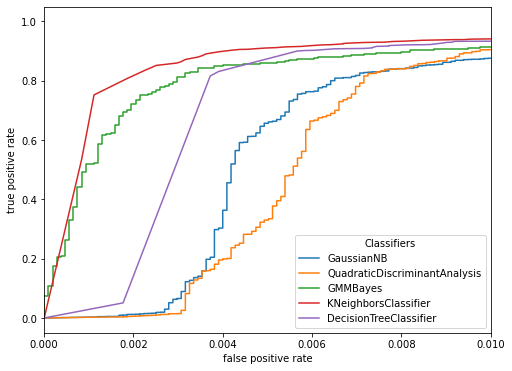

In [46]:
# modified from Lectrue 19 code
def compute_models(*args):
    
    for classifier, kwargs in args:

        clf = classifier(**kwargs)
        clf.fit(Xctrain, yctrain)
        
        ycpred = clf.predict_proba(Xctest)[:, 1]

        # calculate ROC curves as above
        fpr, tpr, thresh = roc_curve(yctest, ycpred)
    
        plt.plot(fpr, tpr, label=classifier.__name__)

    return

plt.figure(figsize=(8,6))

compute_models((GaussianNB, {}),
               (QuadraticDiscriminantAnalysis, {}),
               (GMMBayes, dict(n_components=6)),
               (KNN, dict(n_neighbors=55)),
               (DT, dict(max_depth=7)))

plt.xlim(0, 0.01)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='lower right', title='Classifiers'); 

KNN classifier is the best

10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier.

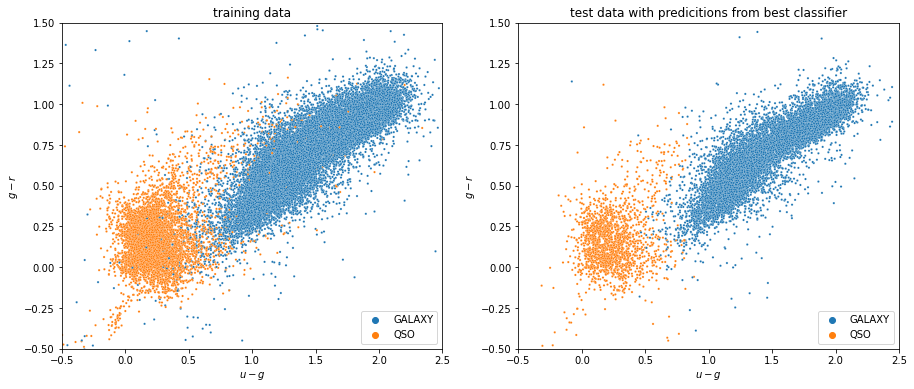

In [48]:
fig, axs = plt.subplots(ncols=2, figsize=(15,6))
labels = np.array(['GALAXY', 'QSO'])

# plot training data
ax = axs[0]
sctrain = labels[yctrain]
scatter = sns.scatterplot(x=Xctrain[:,0], y=Xctrain[:,1],
                          hue=sctrain, s=5, ax=ax)
scatter.legend(loc='lower right')
ax.set_xlabel(r'$u-g$')
ax.set_ylabel(r'$g-r$')
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)
ax.set_title('training data')

# run best classifier
knn = KNN(n_neighbors=55)
knn.fit(Xctrain, yctrain)
ycpred = knn.predict(Xctest)
scpred = labels[ycpred]

# plot predicitions from best classifier
ax = axs[1]
scatter = sns.scatterplot(x=Xctest[:,0], y=Xctest[:,1],
                          hue=scpred, s=5, ax=ax)
scatter.legend(loc='lower right')
ax.set_xlabel(r'$u-g$')
ax.set_ylabel(r'$g-r$')
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)
ax.set_title('test data with predicitions from best classifier');

SRT: Very nice work, William.